In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

## Context Offloading: Filesystem

<img src="./assets/agent_header_files.png" width="800" style="display:block; margin-left:0;">

Agent context windows can grow rapidly during complex tasks—the average Manus task uses approximately 50 tool calls, creating substantial context accumulation. A powerful technique for managing this growth is **context offloading** through filesystem operations. Rather than storing all tool call observations and intermediate results directly in the context window, agents can strategically save information to files and [fetch it as-needed](https://blog.langchain.com/context-engineering-for-agents/), maintaining focus while preserving access to critical information.

This approach has been successfully implemented by production systems like [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research). Anthropic's [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Subagent%20output%20to%20a%20filesystem%20to%20minimize%20the%20%E2%80%98game%20of%20telephone.%E2%80%99) provides another compelling example, where subagents store their work in external systems and pass lightweight references back to coordinators. This prevents the "game of telephone" effect—information degradation as it passes through multiple agents—while enabling fresh subagents to spawn with clean contexts and retrieve stored context like research plans from memory when needed.

By writing token-heavy context to files in sandboxed environments, agents can effectively manage memory while maintaining the ability to retrieve detailed information when necessary. This pattern is particularly valuable for structured outputs like code, reports, or data visualizations where specialized prompts produce better results than filtering through general coordinators, and for long-running research tasks where intermediate results need preservation without constant attention.

### File Tools

Our implementation uses a virtual filesystem approach that mocks the traditional filesystem within LangGraph state. The core insight is to use a simple dictionary where keys represent mock file paths and values contain the file content. This approach provides short-term, thread-wise persistence that's ideal for maintaining context within a single agent conversation, though it's not suited for information that needs to persist across different conversation threads. The file operations utilize LangGraph's `Command` type to update the agent state, enabling tools to modify the virtual filesystem and maintain proper state management throughout the agent's execution.

You’ll build three file tools—`ls`, `read_file`, and `write_file`—that operate on the virtual file system.

**Usage:** 
- When the LLM has information in its context that it wants to persist, it writes it to a file with `write_file`; later, the same agent or a subagent can retrieve it with `read_file`.
- A tool call can write data to a file and provide the filename in the tool call return message to the LLM. The LLM can later decide to read some or all of the content, or could apply another tool to process the data. 
- Use `ls` to list available files.

The read/write tools expect newline-delimited plain text (parsed with `str.splitlines()`).


The descriptions in the prompts below describe in detail how they operate:

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

In [3]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Let's implement these functions below. There are two items worth noting. The first is the use of `@tool(description=PROMPT)`. Note that when `description="xyz" is in the tool decorator, "xyz" is sent to the LLM and the docstring is suppressed. It is often more convenient to have lengthy descriptions in a separate prompts file. This provides space to explain both the operation of the tool and how it should be used in this application. The second item is the error messages. These messages are intended for the LLM vs a human user. In an agentic system, the LLM can use the information in error messages to retry the operation. 

In [6]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py
"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)


@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ../src/deep_agents_from_scratch/file_tools.py


# Revisiting state and reducer 
In the previous notebook, we defined the file state and reducer, but did not describe them. Let's do that here.
In `DeepAgentState`, `files` is defined as a dictionary with a key and value. As was mentioned above, the key is the filename and the value is the content of the file. `files` are added to state using the `file_reducer` when the `Command` in `write_files` is executed. In this reducer, `left` is the existing files in state and `right` is new values. The final statement allows the new values to overwrite old values: `{**left, **right}`, Python unpacks `left` first, then `right`. Any duplicate keys from `right` overwrite the earlier values from `left`.

```python
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]
```

We have a virtual filesystem and tools to work with it.  Let's build a simple research agent to try it out. 
The agent will store the user's request and then read it back before answering the user's question! 

Note that this simple approach is [very useful with long-running agent trajectories](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)! In this simple example, all information is easily kept in context, but for long-running agents, context content can be compressed or eliminated. Storing information prior to compression and retrieving it when it's needed is smart context engineering.

In [7]:
# ============================================================================
# ORIGINAL PROMPT (commented out)
# ============================================================================
# FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.                                  
#                                                                                                                 
# ## Workflow Process                                                                                            
# 1. **Orient**: Use ls() to see existing files before starting work                                             
# 2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     
# 3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that you directly answer the user's question."""
#
# SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""
#
# INSTRUCTIONS = (
#     FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
# )

# ============================================================================
# STRICT PROMPT - Forces sequential tool calls (one at a time)
# ============================================================================
STRICT_WORKFLOW_INSTRUCTIONS = """You have access to a virtual file system and web search to help you complete tasks.

## CRITICAL RULES - READ CAREFULLY:
1. You MUST call tools ONE AT A TIME. Never call multiple tools in a single response.
2. After each tool call, WAIT for the result before calling the next tool.
3. You MUST follow the exact order of steps below. Do NOT skip any step.

## MANDATORY WORKFLOW (Execute in this exact order):

### STEP 1 - ORIENT (REQUIRED):
- Call ls() with no arguments to see existing files
- STOP and wait for the result

### STEP 2 - SAVE REQUEST (REQUIRED):
- Call write_file() to save the user's request to a file named "user_request.txt"
- Include in the file: the original request and what information you need to find
- STOP and wait for the result

### STEP 3 - RESEARCH (REQUIRED):
- Call web_search() with a query based on the user's question
- STOP and wait for the result

### STEP 4 - VERIFY (REQUIRED):
- Call read_file() to read back the "user_request.txt" file
- STOP and wait for the result

### STEP 5 - RESPOND:
- Only after completing ALL 4 tool calls above, provide your final answer
- Use the web search results to answer the user's question

## REMINDER:
- ONE tool call per response
- Wait for each result before proceeding
- Do NOT skip steps
- Do NOT combine multiple tool calls"""

INSTRUCTIONS = STRICT_WORKFLOW_INSTRUCTIONS
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system and web search to help you complete tasks.                            │
│                                                                                                                 │
│  ## CRITICAL RULES - READ CAREFULLY:                                                                            │
│  1. You MUST call tools ONE AT A TIME. Never call multiple tools in a single response.                          │
│  2. After each tool call, WAIT for the result before calling the next tool.                                     │
│  3. You MUST follow the exact order of steps below. Do NOT skip any step.                                       │
│                                                                                                                 │
│  ## MANDATORY WORKFLOW (Execute in this exact order):                                                           │
│                                                                                                                 │
│  ### STEP 1 - ORIENT (REQUIRED):                                                                                │
│  - Call ls() with no arguments to see existing files                                                            │
│  - STOP and wait for the result                                                                                 │
│                                                                                                                 │
│  ### STEP 2 - SAVE REQUEST (REQUIRED):                                                                          │
│  - Call write_file() to save the user's request to a file named "user_request.txt"                              │
│  - Include in the file: the original request and what information you need to find                              │
│  - STOP and wait for the result                                                                                 │
│                                                                                                                 │
│  ### STEP 3 - RESEARCH (REQUIRED):                                                                              │
│  - Call web_search() with a query based on the user's question                                                  │
│  - STOP and wait for the result                                                                                 │
│                                                                                                                 │
│  ### STEP 4 - VERIFY (REQUIRED):                                                                                │
│  - Call read_file() to read back the "user_request.txt" file                                                    │
│  - STOP and wait for the result                                                                                 │
│                                                                                                                 │
│  ### STEP 5 - RESPOND:                                                                                          │
│  - Only after completing ALL 4 tool calls above, provide your final answer                                      │
│  - Use the web search results to answer the user's question                                                     │
│                                                                                                                 │
│  ## REMINDER:                                                                                                   │
│  - ONE tool call per response                                                                                   │
│  - Wait for each result before proceeding             

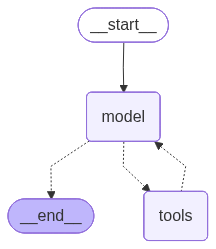

In [8]:
from IPython.display import Image, display
# from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.


    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result

# --- AWS Bedrock Integration ---
# --- Bedrock / Llama Compatibility Patch ---
from langchain_aws import ChatBedrockConverse
import langchain_aws.chat_models.bedrock_converse as bc


# Active Model Selection
# Bedrock Models
llm_nova_lite = ChatBedrockConverse(model="us.amazon.nova-2-lite-v1:0", region_name="us-east-1", temperature=0.0)
llm_nova_pro = ChatBedrockConverse(model="us.amazon.nova-2-pro-v1:0", region_name="us-east-1", temperature=0.0)

model = llm_nova_lite
# Create agent using create_react_agent directly
# model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [ls, read_file, write_file, web_search]

# Create agent with system prompt
agent = create_agent(
    model, tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `files` in state and an user research request. 

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tooluse_CE0CCcoTWBkwS9jmDD5WQT                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.txt",                                                                              │
│   "content": "User is asking for an overview of Model Context Protocol (MCP). Need to gather information about  │
│ MCP through web search and provide a comprehensive overview."                                                   │
│ }                                                                                                               │
│    ID: tooluse_diRJzt4sr4ALqn8nag368H                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.txt                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: tooluse_IhTfwyRCgbA22qmGdHZAak                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "user_request.txt"                                                                               │
│ }                                                                                                               │
│    ID: tooluse_6K2Y80Rv8t7TO00nK5cC4O                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  User is asking for an overview of Model Context Protocol (MCP). Need to gather information about MCP    │
│ through web search and provide a comprehensive overview.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ### **Model Context Protocol (MCP) Overview**                                                                   │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an **open standard protocol** developed by **Anthropic** to enable      │
│ **seamless integration** between **AI models** and **external systems** such as tools, databases, and other     │
│ services. It acts as a **standardized communication layer**, allowing AI models to **access and utilize data**  │
│ from various sources in a **consistent and efficient manner**.                                                  │
│                                                                                                                 │
│ #### **Key Features and Purpose**                                                                               │
│ 1. **Unified Language for Data Exchange**                                                                       │
│    MCP provides a **unified language** for AI models to interact with external services. This eliminates the    │
│ need for custom integrations for each service, streamlining development.                                        │
│                                                                                                                 │
│ 2. **Simplified Integration**                                                                                   │
│    It simplifies the process of connecting AI assistants or agents to external services. Developers can         │
│ leverage MCP to plug in tools or data sources without building service-specific logic into the model.           │
│                                                                                                                 │
│ 3. **Interoperability**                                                                                         │
│    As an open standard, MCP promotes **interoperability** across different AI platforms, tools, and services.   │
│ This allows diverse ecosystems to work together more effectively.                                               │
│                                                                                                                 │
│ 4. **Efficiency and Consistency**                                                                               │
│    By standardizing how models request and receive data, MCP ensures **efficient and consistent** interactions, │
│ reducing errors and improving reliability.                                                                      │
│                                                                                                                 │
│ #### **How MCP Works**                                                                                          │
│ - **Standardized API**: MCP defines a set of **standardized APIs** that models use to request data or perform   │
│ actions on external systems.                                                                                    │
│ - **Contextual Awareness**: Models can maintain **context** about their environment and the data they access,   │
│ enabling more intelligent and context-aware responses.                                                          │
│ - **Tool Integration**: External tools (e.g., databases, APIs, calculators) can be integrated into the AI’s     │
│ workflow through MCP, allowing the model to leverage these tools as needed.                                     │
│                                                                                                                 │
│ #### **Use Cases**                                                                                              │
│ - **AI Assistants**: Enables AI assistants to access re

We can see the file saved in our mock file system. 

In [10]:
result["files"]

{'user_request.txt': 'User is asking for an overview of Model Context Protocol (MCP). Need to gather information about MCP through web search and provide a comprehensive overview.'}

Trace: 
https://smith.langchain.com/public/b03e20b4-e908-488d-84a9-8f891d17addd/r
<!-- https://smith.langchain.com/public/1066102f-d7b3-423c-b556-006865a1d479/r -->